In [1]:
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(3)
torch.cuda.is_available()

True

## Working with iris dataset

In [3]:
X, y = load_iris(return_X_y=True)
X, y = torch.FloatTensor(X), torch.LongTensor(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
X_train, X_test, y_train, y_test = X_train.to('cuda'), X_test.to('cuda'), y_train.to('cuda'), y_test.to('cuda')

In [4]:
## Building network
class Model(nn.Module):

    def __init__(self, n_features=4, h1=10, h2=6, n_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(n_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, n_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [92]:
my_model = Model()
my_model.to('cuda')

# Loss criteria with cross entropy
criterion = nn.CrossEntropyLoss()

# Optimiser
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.01)

# LR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.75)

In [93]:
def train(model: nn.Module, epochs: int):
    best_model_wts = deepcopy(model.state_dict())
    least_loss = np.inf
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs - 1}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                y_pred = model(X_train)
                loss = criterion(y_pred, y_train)
                train_losses.append(loss.detach().cpu().numpy())

                torch.enable_grad()
                optimizer.zero_grad() # Clear gradients
                loss.backward() # Backpropagation, co   mpute gradients
                optimizer.step()
                scheduler.step()

            else:
                model.eval()
                torch.no_grad()
                y_pred = model(X_test)
                loss = criterion(y_pred, y_test)
                test_losses.append(loss.detach().cpu().numpy())

                if test_losses[-1] < least_loss:
                    least_loss = test_losses[-1]
                    best_model_wts = deepcopy(model.state_dict())

        # print every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch: {epoch} and training loss: {train_losses[-1]}, test loss: {test_losses[-1]}')

    # load the best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses


In [94]:
best_model, train_losses, test_losses = train(my_model, epochs=100)

Epoch 0/99
Epoch: 0 and training loss: 1.113469123840332, test loss: 1.0428977012634277
Epoch 1/99
Epoch 2/99
Epoch 3/99
Epoch 4/99
Epoch 5/99
Epoch 6/99
Epoch 7/99
Epoch 8/99
Epoch 9/99
Epoch 10/99
Epoch: 10 and training loss: 0.8394724726676941, test loss: 0.7771486639976501
Epoch 11/99
Epoch 12/99
Epoch 13/99
Epoch 14/99
Epoch 15/99
Epoch 16/99
Epoch 17/99
Epoch 18/99
Epoch 19/99
Epoch 20/99
Epoch: 20 and training loss: 0.5592511296272278, test loss: 0.49676641821861267
Epoch 21/99
Epoch 22/99
Epoch 23/99
Epoch 24/99
Epoch 25/99
Epoch 26/99
Epoch 27/99
Epoch 28/99
Epoch 29/99
Epoch 30/99
Epoch: 30 and training loss: 0.3563069701194763, test loss: 0.31743258237838745
Epoch 31/99
Epoch 32/99
Epoch 33/99
Epoch 34/99
Epoch 35/99
Epoch 36/99
Epoch 37/99
Epoch 38/99
Epoch 39/99
Epoch 40/99
Epoch: 40 and training loss: 0.239833801984787, test loss: 0.22144381701946259
Epoch 41/99
Epoch 42/99
Epoch 43/99
Epoch 44/99
Epoch 45/99
Epoch 46/99
Epoch 47/99
Epoch 48/99
Epoch 49/99
Epoch 50/99
Epo

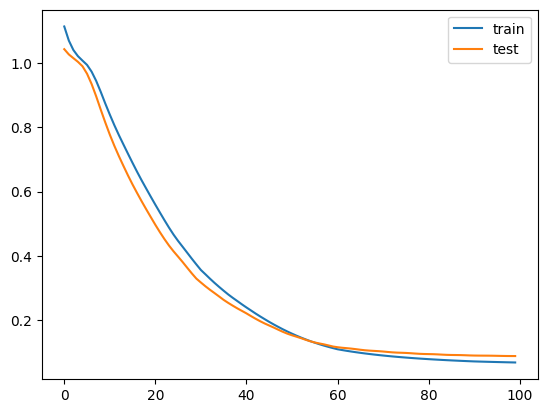

In [95]:
plt.figure()
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.legend()

In [96]:
best_model(X_test).argmax(axis=1), y_test

(tensor([0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 1,
         0, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 2],
        device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 2, 2, 0, 2, 2, 2, 1,
         0, 2, 2, 1, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0, 0, 2],
        device='cuda:0'))